In [1]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 1.8 MB/s eta 0:00:00


# IMPORT LIBRARIES

In [2]:
# ===== Standard =====
import os
import time

# ===== PyTorch =====
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# ===== torchvision =====
from torchvision import datasets, transforms

# ===== snntorch =====
import snntorch as snn
from snntorch import spikegen, spikeplot as splt, utils

# ===== Other =====
import numpy as np
import matplotlib.pyplot as plt

# SET RANDOM SEED

In [3]:
np.random.seed(22520195)

# HELPER FUNCTION

In [4]:
def plot_potential_and_spikes(mem_potential, spikes, title, dt):
    """Plots membrane potential and spike times."""
    time_steps = np.arange(len(mem_potential)) * dt
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color = 'tab:blue'
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Membrane Potential (V)', color=color)
    ax1.plot(time_steps, mem_potential, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(min(mem_potential) - 0.01, max(mem_potential) + 0.01) # Adjust ylim for visibility

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    # ax2.set_ylabel('Spike', color=color)  # we already handled the x-label with ax1
    spike_times = np.where(spikes == 1)[0] * dt
    if len(spike_times) > 0 :
      ax2.eventplot(spike_times, linelengths=0.8, color=color, orientation='horizontal', lineoffset=0) # Draw spikes as vertical lines
    ax2.set_yticks([]) # Hide y-axis ticks for spikes
    # ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 1) # Spike axis from 0 to 1

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_stdp_window(delta_t_values, delta_w_values, title="STDP Weight Change Window"):
    """Plots the classic STDP weight change curve."""
    plt.figure(figsize=(8, 5))
    plt.plot(delta_t_values[delta_t_values < 0], delta_w_values[delta_t_values < 0], 'o-', label='LTD (Post before Pre)')
    plt.plot(delta_t_values[delta_t_values > 0], delta_w_values[delta_t_values > 0], 'o-', label='LTP (Pre before Post)')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.xlabel('Δt = t_post - t_pre (ms)')
    plt.ylabel('Δw (Weight Change)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# DEVICE SETUP

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 52.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.88MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.65MB/s]


Epoch 1: Test Accuracy = 97.77%
Epoch 2: Test Accuracy = 98.00%
Epoch 3: Test Accuracy = 98.66%
Epoch 4: Test Accuracy = 98.92%
Epoch 5: Test Accuracy = 98.92%
Epoch 6: Test Accuracy = 98.75%
Epoch 7: Test Accuracy = 99.23%
Epoch 8: Test Accuracy = 99.01%
Epoch 9: Test Accuracy = 99.15%
Epoch 10: Test Accuracy = 99.20%
Original CNN Test Accuracy: 99.20%
Converted SNN Test Accuracy: 97.97%
Note: Accuracy drop after conversion is expected due to discrete spikes and rate encoding.


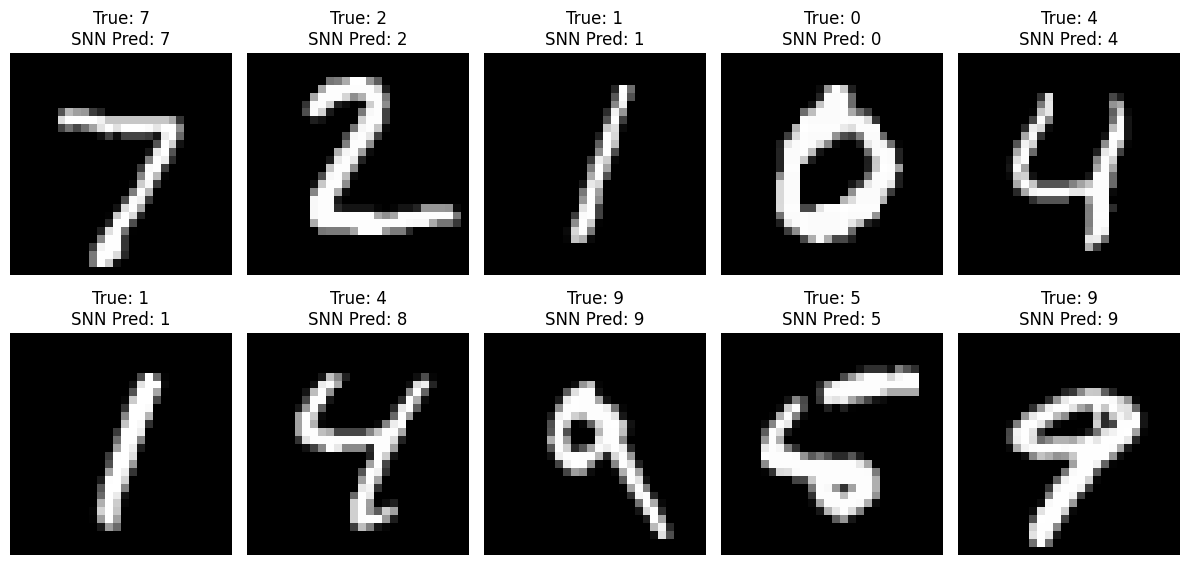

In [6]:
# ========= Constants and Parameters =========
batch_size = 128
data_path = '/content/data/mnist_csnn_pretrained'  # Đường dẫn dùng trong Google Colab
cnn_weights_path = '/content/mnist_cnn_pretrained.pth'  # Nơi lưu trọng số CNN
num_steps_snn = 50  # Số bước thời gian cho SNN — càng nhiều bước càng chính xác
beta = 0.95  # Hệ số rò rỉ của neuron LIF
learning_rate_cnn = 1e-3
num_epochs_cnn = 10  # Số epoch huấn luyện CNN

# ========= Device Setup =========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Chạy trên GPU nếu có

# ========= MNIST Data Setup =========
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Chuẩn hóa ảnh MNIST (mean, std)
])

# Tải dataset MNIST
mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Tạo DataLoader
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, drop_last=True)

# ========= Step 1: Define the Simple CNN Architecture =========
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # CNN cơ bản với AvgPool (dễ chuyển sang SNN hơn MaxPool)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2, bias=False)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2, bias=False)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 7 * 7, 120, bias=False)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 10, bias=False)  # Output: 10 class MNIST

    def forward(self, x):
        # Truyền tín hiệu qua các lớp CNN
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

# ========= Step 2: Train the CNN =========
def train_cnn(model, train_loader, test_loader, optimizer, criterion, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # Sau mỗi epoch, đánh giá mô hình trên tập test
        test_acc = evaluate_cnn(model, test_loader, device)
        print(f"Epoch {epoch+1}: Test Accuracy = {test_acc:.2f}%")

def evaluate_cnn(model, data_loader, device):
    # Hàm đánh giá chính xác của CNN
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return 100 * correct / total

# Nếu chưa có trọng số CNN đã huấn luyện thì huấn luyện từ đầu
cnn_model = SimpleCNN().to(device)
if not os.path.exists(cnn_weights_path):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate_cnn)
    train_cnn(cnn_model, train_loader, test_loader, optimizer, criterion, num_epochs_cnn, device)
    torch.save(cnn_model.state_dict(), cnn_weights_path)
else:
    cnn_model.load_state_dict(torch.load(cnn_weights_path, map_location=device))
    cnn_accuracy = evaluate_cnn(cnn_model, test_loader, device)
    print(f"Loaded CNN Test Accuracy: {cnn_accuracy:.2f}%")

# ========= Step 3: Define the Spiking CNN (CSNN) =========
class SpikingCNN(nn.Module):
    def __init__(self, beta_lif=0.95):
        super().__init__()
        # Các layer giống hệt CNN gốc để có thể load weight
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2, bias=False)
        self.pool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2, bias=False)
        self.pool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 7 * 7, 120, bias=False)
        self.fc2 = nn.Linear(120, 10, bias=False)

        # Thay ReLU bằng các neuron LIF
        self.lif1 = snn.Leaky(beta=beta_lif, init_hidden=True)
        self.lif2 = snn.Leaky(beta=beta_lif, init_hidden=True)
        self.lif3 = snn.Leaky(beta=beta_lif, init_hidden=True)
        self.lif4 = snn.Leaky(beta=beta_lif, init_hidden=True, output=True)  # Output layer

    def forward(self, x, num_steps):
        # Mã hóa ảnh thành spike train bằng rate coding
        spike_input = spikegen.rate(x, num_steps=num_steps)

        # Reset trạng thái của các neuron trước mỗi forward
        self.lif1.reset_hidden()
        self.lif2.reset_hidden()
        self.lif3.reset_hidden()
        self.lif4.reset_hidden()

        spk4_rec = []
        for step in range(num_steps):
            current_input = spike_input[step]
            cur1 = self.pool1(self.conv1(current_input))
            spk1 = self.lif1(cur1)
            cur2 = self.pool2(self.conv2(spk1))
            spk2 = self.lif2(cur2)
            cur3 = self.fc1(self.flatten(spk2))
            spk3 = self.lif3(cur3)
            cur4 = self.fc2(spk3)
            spk4, _ = self.lif4(cur4)
            spk4_rec.append(spk4)

        # Trả về toàn bộ spike output qua thời gian
        return torch.stack(spk4_rec, dim=0)

# ========= Step 4: Instantiate SNN and Load Weights =========
snn_model = SpikingCNN(beta_lif=beta).to(device)

# Load trọng số từ CNN vào SNN — strict=False để bỏ qua ReLU (không tồn tại trong SNN)
snn_model.load_state_dict(torch.load(cnn_weights_path, map_location=device), strict=False)

# ========= Step 5 & 6: Evaluate the Converted SNN =========
def evaluate_snn(model, data_loader, num_steps, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            # Output là spike qua thời gian: [T, B, C]
            output_spikes = model(data, num_steps)
            spike_counts = torch.sum(output_spikes, dim=0)  # Tổng số spike mỗi class
            _, predicted = torch.max(spike_counts, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return 100 * correct / total

# Đánh giá SNN
snn_accuracy = evaluate_snn(snn_model, test_loader, num_steps_snn, device)

# ========= Kết quả =========
cnn_accuracy_final = evaluate_cnn(cnn_model, test_loader, device)
print(f"Original CNN Test Accuracy: {cnn_accuracy_final:.2f}%")
print(f"Converted SNN Test Accuracy: {snn_accuracy:.2f}%")
print("Note: Accuracy drop after conversion is expected due to discrete spikes and rate encoding.")

# ========= Visualize a few predictions =========
data_sample, targets_sample = next(iter(test_loader))
data_sample, targets_sample = data_sample.to(device), targets_sample.to(device)

# Lấy prediction từ SNN cho vài ảnh đầu tiên
with torch.no_grad():
    output_spikes_sample = snn_model(data_sample, num_steps_snn)
    spike_counts_sample = torch.sum(output_spikes_sample, dim=0)
    _, predicted_sample = torch.max(spike_counts_sample, 1)

# Un-normalize ảnh để hiển thị
unorm = transforms.Normalize((-0.1307 / 0.3081,), (1 / 0.3081,))
data_sample_cpu = unorm(data_sample.cpu())

# Vẽ ảnh và nhãn dự đoán
plt.figure(figsize=(12, 6))
for i in range(min(10, batch_size)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(data_sample_cpu[i].squeeze(), cmap="gray")
    plt.title(f"True: {targets_sample[i].item()}\nSNN Pred: {predicted_sample[i].item()}")
    plt.axis("off")
plt.tight_layout()
plt.show()